### Get a Time Series to analyze

In [30]:
import seaborn as sns
%matplotlib inline

df = sns.load_dataset('flights')

In [31]:
import pandas as pd

ts = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
df.set_index(ts, inplace=True)

df['pct'] = df['passengers'].pct_change()

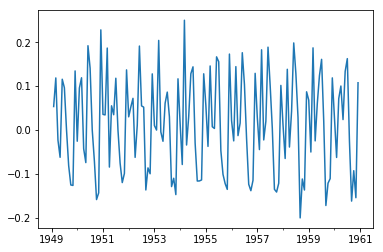

In [32]:
df['pct'].plot()

In [33]:
del df['year']
del df['month']

In [34]:
df.head(5)

,passengers,pct
1949-01-01,112,NaN
1949-02-01,118,0.053571
1949-03-01,132,0.118644
1949-04-01,129,-0.022727
1949-05-01,121,-0.062016


In [23]:
df['lag1'] = df['passengers'].shift(1)
df['lag2'] = df['passengers'].shift(2)
df['lag3'] = df['passengers'].shift(3)
df['lag12'] = df['passengers'].shift(12)

option: use the Data Frame with any supervised learning method, e.g. adding extra features --> multinomial forecast

In [36]:
df.dropna(inplace=True)

In [21]:
df.corr()

,passengers,lag1,lag2,lag3
passengers,1.000000,0.959182,0.894402,0.837395
lag1,0.959182,1.000000,0.959707,0.894473
lag2,0.894402,0.959707,1.000000,0.961133
lag3,0.837395,0.894473,0.961133,1.000000


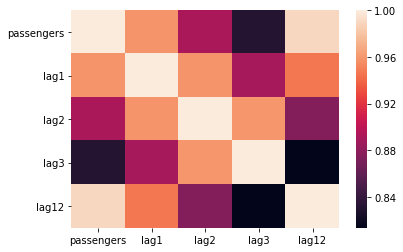

In [24]:
sns.heatmap(df.corr())

## ARIMA models require the data to be stationary

1. Non-seasonal
2. Without a trend

**We want to exclude autocorrelation**. We call a non-autocorrelated time series **stationary**.

### Autocorrelation
correlation for each time shift -> heatmap + ACF plot

if the ACF plot drops quickly to near-zero, you have neither a trend nor seasonality

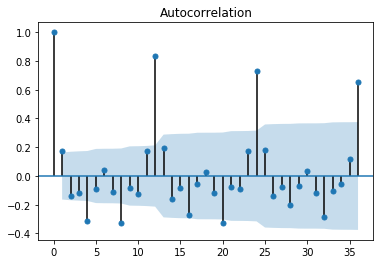

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

a = plot_acf(df['pct'], lags=36)

### Autoregressive Model

p - hyperparameter: how many periods we look into the past

AR(p):

$y_t = c + w_1 y_{t-1} + w_2 y_{t-2} .. + w_p y_{t-p} + \epsilon_t$

In [54]:
# generate data (200 periods) using an AR(2) process
import random
from matplotlib import pyplot as plt
random.seed(42)

data = [20.0, 20.0]
x = range(200)
c = 8.0
w1 = 1.3
w2 = -0.7

for i in range(198):
    yt = c + w1 * data[-1] + w2 * data[-2] + random.gauss(0.0, 0.1)
    data.append(yt)

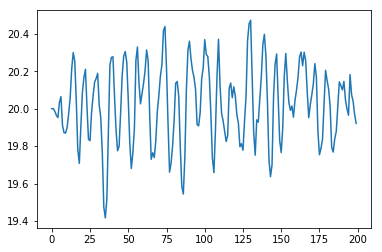

In [55]:
plt.plot(x, data)

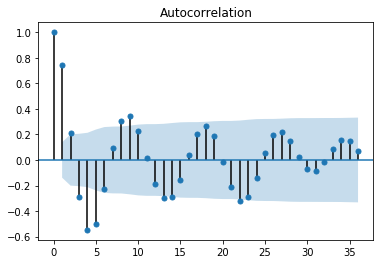

In [56]:
a = plot_acf(data, lags=36)

Based on the ACF plot, we assume our data is stationary (in fact it is so-so because of an unknown artifact).

If we wanted to go really sure, do a hypothesis test (Ljung-Box test, see green book by Hyndman et al.)

### Initialize and fit an ARIMA model

also see: Seasonal Arima (SARIMAX)

In [63]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

ytrain = data[:150] # different from sklearn train_test_split
ytest = data[150:]  # test set is always the last part of your data

# (ar, d, ma) <- Order of the ARIMA model
#                (usually small numbers)
# ar - autoregressive part (0 to 3)
#  d - differencing (0 or 1)
# ma - moving average part (Moving Average of the residuals!!, 0 to 3)
m = ARIMA(ytrain, (2, 0, 0))
m.initialize()
r = m.fit()

/home/kristian/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/kristian/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/kristian/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

In [64]:
r.params

array([20.01827678,  1.32346289, -0.77400589])

In [65]:
# prediction for future periods (xtest)
ypred, err, conf = r.forecast(steps=50) # predicted, error, confidence
ypred.shape

(50,)

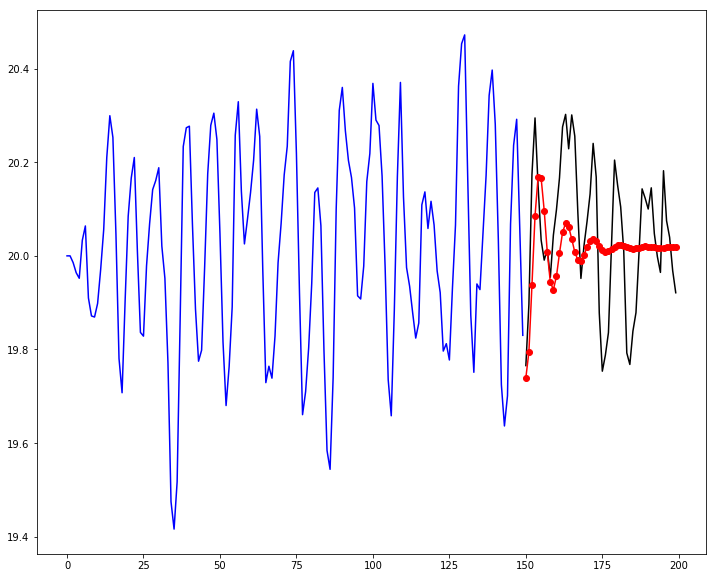

In [66]:
plt.figure(figsize=(12, 10))
plt.plot(range(150), ytrain, color='blue')
plt.plot(range(150, 200), ytest, color='black')
plt.plot(range(150, 200), ypred, color='red', marker='o')

### Re-train the ARIMA model to make 1-period forecasts

In [67]:
result = []
for x in range(150, 200):
    ytrain = data[:x]
    m = ARIMA(ytrain, (2, 1, 2))
    m.initialize()
    r = m.fit()
    # now predict 1 period at a time
    ypred, err, conf = r.forecast(steps=1)
    result.append(ypred[0])

/home/kristian/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kristian/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kristian/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kristian/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kristian/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/kristian/anaconda3/lib/python3.6/site-pack

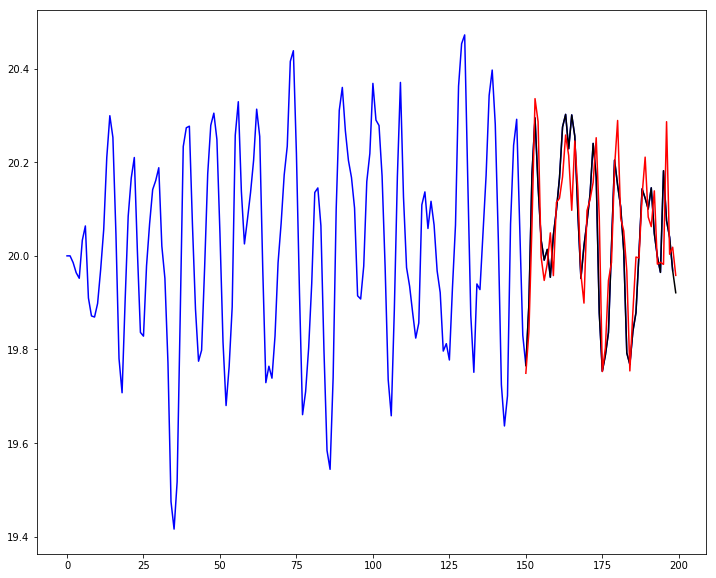

In [68]:
plt.figure(figsize=(12, 10))
plt.plot(range(199), ytrain, color='blue')
plt.plot(range(150, 200), ytest, color='black')
plt.plot(range(150, 200), result, color='red')